<a href="https://colab.research.google.com/github/christian-byrne/tucson-crime-models/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

## Configuration & Constants

In [116]:
from pathlib import Path
from typing import Union, Dict, Any, Tuple, Dict, List, Optional


class Config:
    # Embedded configuration data
    _config_data: Dict[str, Any] = {
        # hyperparameters
        "hp": {
            # the ratio of the dataset to use for testing
            "test_size" : 0.2,
            "subsection_count": 6,  # Number of subsections to divide the city into
            # the number of cross-validation folds to use for each model
            "cross_val_folds": {
                "linear": 5,
                "best_subset": 5,
                "lasso": 5,
                "ridge": 5,
            },
            # the scoring metric to use for each model during cross-validation
            "scoring_metric": {
                "best_subset": "r2",
                "lasso": "r2",
                "ridge": "r2",
            },
            # the sparse infrastructure types to calculate distance-to for
            "distance_to_nearest_infrastructure": [
                "fire_stations",
                "landfills",
                "streetcar_stops",
            ],
            "count_instances_infrastructure": [
                "bicycle_boulevards",
                "bridges",
                "crosswalks",
                "business_licenses",
                # "fire_stations",
                # "landfills",
                "major_streets",
                "streetcar_routes",
                # "streetcar_stops",
                "scenic_routes",
                "sidewalks",
                "streetlights",
                "suntran_stops",
            ],
            # the method to use to determine whether an infrastructure type is considered "nearby"
            # Use `geometry.within` to check if the object is fully contained within the subsection
            # Use `geometry.intersects` to check if geometries share any part of their space
            # Use `geometry.overlaps` to check if geometries overlap, but it excludes cases where one geometry entirely contains or is entirely contained by the other
            "geometry_contains_method": {
                "arrests": "within",
                "bicycle_boulevards": "intersects",
                "bridges": "within",
                "business_licenses": "within",
                "crosswalks": "intersects",
                "fire_stations": "within",
                "landfills": "within",
                "major_streets": "intersects",
                "streetcar_routes": "intersects",
                "streetcar_stops": "within",
                "scenic_routes": "intersects",
                "sidewalks": "intersects",
                "streetlights": "within",
                "suntran_stops": "within",
            },
        },
        # model config
        "feature_names" : {
            "model1" : [
                "bicycle_boulevards",
                "bridges",
                "crosswalks",
                "fire_stations",
                "landfills",
                "major_streets",
                "streetcar_routes",
                "streetcar_stops",
                "scenic_routes",
                "sidewalks",
                "streetlights",
                "suntran_stops",
            ],
        },
        # dev config
        "log_level": "WARNING",
        # data config
        "tucson_center_coordinates": [32.2226, -110.9747],
        "tucson_bounds": [-111, 32.0, -110.9747, 32.2226],
        "data_sources": {
            "arrests": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/crime/Tucson_Police_Arrests_-_2017_-_Open_Data.geojson",
            "bicycle_boulevards": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Bicycle_Boulevards.geojson",
            "bridges": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Bridges_-_Open_Data.geojson",
            "business_licenses": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Business_Licenses_(Open_Data).geojson",
            "crosswalks": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Crosswalks_-_Open_Data.geojson",
            "fire_stations": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Fire_Stations.geojson",
            "landfills": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Landfills_(Eastern_Pima_County).geojson",
            "major_streets": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Major_Streets_and_Routes_-_Open_Data.geojson",
            "streetcar_routes": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Modern_Streetcar_Route_(Polygon)_-_Open_Data.geojson",
            "streetcar_stops": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Modern_Streetcar_Stops_-_Open_Data.geojson",
            "scenic_routes": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Scenic_Routes_-_Open_Data.geojson",
            "sidewalks": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Sidewalks.geojson",
            "streetlights": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Streetlights_-_City_of_Tucson_-_Open_Data.geojson",
            "suntran_stops": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Sun_Tran_Bus_Stops_-_Open_Data.geojson",
        },
    }

    def __getitem__(self, key: str) -> Any:
        """Get a configuration value by key, with KeyError if missing."""
        if key not in Config._config_data:
            msg = (
                f"Could not find key '{key}' in config."
                + f"Available keys: {list(Config._config_data.keys())}"
            )
            raise KeyError(msg)
        return Config._config_data[key]

    def __setitem__(self, key: str, value: Union[str, Path]) -> None:
        """Set a configuration value by key, converting Path to string if necessary."""
        if isinstance(value, Path):
            value = str(value.resolve())
        Config._config_data[key] = value

    @classmethod
    def get_all(cls) -> Dict[str, Any]:
        """Return the entire configuration data dictionary."""
        return cls._config_data


config = Config()

## Logging Utils

In [96]:
import logging
from rich.logging import RichHandler


class Logger:
    def __init__(self, logger_name: str, level: int = logging.INFO):
        self.logger_base = logging.getLogger(logger_name)

        # Ensure no handlers are duplicated and set propagate to False
        self.logger_base.handlers.clear()
        self.logger_base.propagate = False

        rich_handler = RichHandler(
            rich_tracebacks=True, tracebacks_show_locals=True, markup=True
        )

        formatter = logging.Formatter("%(message)s")
        rich_handler.setFormatter(formatter)

        self.logger_base.addHandler(rich_handler)
        self.logger_base.setLevel(level)

    def __call__(self):
        return self.logger_base


logger = Logger("General", config["log_level"])()

# Model 1—Subsection-Level Crime Frequency Prediction Using Infrastructure and Socioeconomic Features

## 1—Data Collection

### 1.1—Fetch and Load Datasets from Repo

In [97]:
import geopandas as gpd
import requests
from typing import Dict

# Dictionary to cache datasets in memory to prevent re-fetching in same session
_cache: Dict[str, gpd.GeoDataFrame] = {}


def load_dataset(dataset_name: str):
    # Check if the dataset is already cached
    if dataset_name in _cache:
        logger.info(f"Using cached data for {dataset_name}")
        return _cache[dataset_name]

    # Load the dataset from Config if not cached
    filepath = config["data_sources"][dataset_name]

    if filepath.startswith("http"):
        logger.info(f"Downloading dataset from {filepath}")
        response = requests.get(filepath)
        response.raise_for_status()
        with open(f"/tmp/{dataset_name}.geojson", "wb") as f:
            f.write(response.content)
        dataframe = gpd.read_file(f"/tmp/{dataset_name}.geojson")
    else:
        dataframe = gpd.read_file(filepath)

    logger.info(f"Loaded data from {filepath}")
    logger.debug(
        f"Columns in {filepath.split('/')[-1]}:\n{', '.join(dataframe.columns)}"
    )

    # Cache the loaded dataset
    _cache[dataset_name] = dataframe

    return dataframe

## 2—Data Processing and Cleaning

### 2.1—Remove NaN and Null

In [98]:
arrests_data = load_dataset("arrests")

# TODO: fix these
# remove null values from the dataset
# arrests_data = arrests_data.dropna()

# remove any rows with missing location data
# arrests_data = arrests_data.dropna(subset=["geometry"])

### 2.1—Filter GIS Data by Bounds

In [99]:
import geopandas as gpd
from shapely.geometry import box


def filter_by_bounds(data: gpd.GeoDataFrame, bounds: tuple) -> gpd.GeoDataFrame:
    """
    Filters the GeoDataFrame to include only points within the specified bounds.

    Parameters:
    data (GeoDataFrame): The data to filter.
    bounds (tuple): A tuple (minx, miny, maxx, maxy) defining the bounding box.

    Returns:
    GeoDataFrame: Filtered GeoDataFrame with points within the bounds.
    """
    logger.debug(f"Filtering data by bounds: {bounds}")
    bbox = box(*bounds)

    if len(data) == 0:
        logger.error("No data found in the input GeoDataFrame. Check the input data.")
        return data

    # Filter data by checking if geometry is within the bounding box
    filtered = data[data.geometry.within(bbox)]
    logger.info(
        f"Filtered out {len(data) - len(filtered)} rows outside the bounds. {len(filtered)} rows remaining."
    )

    if len(data) == len(filtered):
        logger.warning("All data is within the specified bounds. No data was filtered.")

    if len(filtered) == 0:
        logger.error(
            f"All data was filtered out. Check that the bounds {bounds} are correct."
        )

    return filtered

### 2.2—Construct/Partition Subsections

In [100]:
import folium


def create_subsections(number, bbox):
    """
    Params:
    number: int - number of subsections
    bbox: tuple[Float] - (min_x, min_y, max_x, max_y) - bounding box of the area to be divided

    Returns:
    subsections: list[tuple[Float]] -
      list of tuples (min_x, min_y, max_x, max_y) representing the subsections of the area

    """
    min_x, min_y, max_x, max_y = bbox
    x_diff = (max_x - min_x) / number
    y_diff = (max_y - min_y) / number

    subsections = []
    for i in range(number):
        for j in range(number):
            subsections.append(
                (
                    min_x + i * x_diff,
                    min_y + j * y_diff,
                    min_x + (i + 1) * x_diff,
                    min_y + (j + 1) * y_diff,
                )
            )

    return subsections

In [101]:
print(f"Partitioning Tucson into {config['hp']['subsection_count']} subsections")
SUBSECTIONS = create_subsections(config['hp']["subsection_count"], config["tucson_bounds"])

Partitioning Tucson into 6 subsections


## 3—Exploratory Data Analysis and Data Visualization

### 3.1—Visualize the Partitioned Subsections (Data Records/Items) on a Geographic Map

In [102]:
from typing import Optional


def create_map(
    data: gpd.GeoDataFrame,
    location: list = None,
    zoom_start: int = 12,
    popup_field: Optional[str] = None,
    save_path: Union[str, Path, None] = None,
):
    """
    Create a folium map with markers for each point in the input GeoDataFrame.

    Parameters:
    data (GeoDataFrame): The data to plot, must contain 'geometry' column.
    location (list): Latitude and longitude to center the map on. Default is Tucson, AZ.
    zoom_start (int): Initial zoom level for the map.
    popup_field (str, optional): Column name to use for the marker popups. If None, no popups.
    save_path (str or Path, optional): Path to save the generated map HTML file.

    Returns:
    folium.Map: A map with a marker for each point in data.
    """
    if len(data) == 0:
        logger.error("No data found in the input GeoDataFrame. Check the input data.")

    # Default location to Tucson, AZ if not provided
    location = location or config["tucson_center_coordinates"]

    logger.info(f"Creating map centered at {location} with zoom level {zoom_start}...")
    map_canvas = folium.Map(location=location, zoom_start=zoom_start)

    logger.debug("Filtering out rows with missing or non-Point geometry")
    data = data[data.geometry.notnull() & (data.geometry.type == "Point")]

    logger.info(f"Adding {len(data)} points to the map")
    for _, row in data.iterrows():
        # Retrieve the popup content if specified and available
        popup_text = (
            str(row[popup_field]) if popup_field and popup_field in row else None
        )
        folium.Marker([row.geometry.y, row.geometry.x], popup=popup_text).add_to(
            map_canvas
        )

    # Save map to HTML if save_path is specified
    if save_path:
        save_path = Path(save_path) if isinstance(save_path, str) else save_path
        map_canvas.save(save_path)
        logger.info(f"Map saved at {save_path}")

    # Display the map inline in the notebook
    # display(map_canvas) # NOTE: this happens automatically in collab

    return map_canvas

### 3.2—Distribution of Infrastructure Features

In [103]:
def visualize_subsections_on_map(
    subsections, center_coordinates, zoom_start=12, fill_opacity=0.2, color="blue"
):
    """
    Visualize the geographical subsections on a Folium map.

    Parameters:
    subsections: list[tuple[float]] - List of bounding boxes for subsections in (min_x, min_y, max_x, max_y) format.
    center_coordinates: list[float] - Coordinates to center the map on.
    zoom_start: int - Initial zoom level for the map.

    Returns:
    folium.Map: The Folium map with subsections visualized.
    """
    # Create a Folium map centered at the given location
    folium_map = folium.Map(location=center_coordinates, zoom_start=zoom_start)

    # Add rectangles for each subsection
    for subsection in subsections:
        bounds = [[subsection[1], subsection[0]], [subsection[3], subsection[2]]]
        folium.Rectangle(
            bounds, color=color, fill=True, fill_opacity=fill_opacity
        ).add_to(folium_map)

    return folium_map

In [104]:
visualize_subsections_on_map(SUBSECTIONS, config["tucson_center_coordinates"])

### 3.3—Scatterplot of Crime Incidents on a Geographic Map

In [105]:
# TODO: find way to have less items, current number of dots in scatter plot won't load
# create_map(arrests_data, popup_field="ArrestChargeandDescription")

### 3.4—Heatmap of Crime Incidents on a Geographic Map

In [106]:
# TODO

### 3.5—Scatterplot of Infrastructure Features on a Geographic Map

In [107]:
def visualize_objects_in_subsection(
    objects,
    subsection,
    center=config["tucson_center_coordinates"],
    zoom_start=12,
    fill_opacity=0.2,
):
    """
    Accept list of locations of objects (sidewalk, landfill, crosswalk, etc.) and a list of subsections. For each object, if it is in one of the subsections, plot the object on a folium map.

    Params:
    objects: GeoDataFrame - locations of objects
    subsections: list[tuple[Float]] - List of bounding boxes for subsections in (min_x, min_y, max_x, max_y) format.

    Returns:
    folium.Map: The Folium map with objects visualized.

    """
    # Create a Folium map centered at the given location
    folium_map = folium.Map(
        location=center,
        zoom_start=zoom_start,
        # control_scale=True,
        # preferCanvas=True
    )

    # Add rectangles for each subsection
    for subsection in SUBSECTIONS:
        bounds = [[subsection[1], subsection[0]], [subsection[3], subsection[2]]]
        folium.Rectangle(
            bounds, color="blue", fill=True, fill_opacity=fill_opacity
        ).add_to(folium_map)

    # Add objects within subsections
    for _, obj in objects.iterrows():
        for subsection in SUBSECTIONS:
            subsection_box = box(*subsection)
            # Check if the object is within the subsection
            if obj.geometry.intersects(subsection_box):

                # If the object is a point, add a marker
                if obj.geometry.geom_type == "Point":
                    folium.Marker(
                        [obj.geometry.y, obj.geometry.x], popup=obj["OBJECTID"]
                    ).add_to(folium_map)

                # If the object is a line, add a polyline
                elif obj.geometry.geom_type == "LineString":
                    coords = [(point[1], point[0]) for point in obj.geometry.coords]
                    folium.PolyLine(
                        coords, color="red", weight=2.5, opacity=0.8
                    ).add_to(folium_map)

    return folium_map

#### Sidewalks

In [108]:
# Visualize the sidewalks in each subsection
sidewalks_data = load_dataset("sidewalks")
visualize_objects_in_subsection(sidewalks_data, SUBSECTIONS)
# folium_map

### 3.6—Visualize Scatterplot of Socioeconomic Features on a Geographic Map

In [109]:
# TODO

## 4—Analysis, Hypothesis, Testing, Feature Engineering

### 4.1—Feature Engineering

#### 4.1.1—Create Distance-to-Nearest-Instance Features

For some of the infrastructure features, there may be a relatively small number of instances in the dataset (e.g., there's $< 10$ fire stations). In this case, we can create a new feature that represents the distance to the nearest instance of that feature. This will allow us to use the infrastructure features in our model without overfitting to the small number of instances.

In [110]:
# NOTE: This approach works well for moderately sized datasets but could become slow for very large ones. For large datasets, spatial indexing or more advanced spatial joins might be needed (e.g., using scipy’s cKDTree for faster nearest-neighbor searches).
def distance_join(
    main_gdf, ref_gdf, ref_col_name="nearest_id", distance_col_name="distance_to"
):
    """
    Adds a column to the main GeoDataFrame with the ID of the nearest feature
    from the reference GeoDataFrame.

    Parameters:
    main_gdf (GeoDataFrame): The main GeoDataFrame, typically with Point geometries (e.g., arrests data).
    ref_gdf (GeoDataFrame): The reference GeoDataFrame to find the nearest feature from (e.g., sidewalks).
    ref_col (str): The name of the new column in main_gdf to store the ID of the nearest feature.
    distance_col (str, optional): If provided, stores the distance to the nearest feature in this column.

    Returns:
    GeoDataFrame: The main GeoDataFrame with an added column for the nearest feature's ID.
    """
    # Ensure both GeoDataFrames are in the same CRS, convert to a metric CRS for distance calculation
    metric_crs = "EPSG:3857"
    main_gdf = main_gdf.to_crs(metric_crs)
    ref_gdf = ref_gdf.to_crs(metric_crs)

    # Prepare the new columns in main_gdf
    main_gdf[ref_col_name] = None
    if distance_col_name:
        main_gdf[distance_col_name] = None

    # For each geometry in main_gdf, find the closest geometry in ref_gdf
    for idx, main_geom in main_gdf.iterrows():
        # Find the nearest geometry in ref_gdf
        nearest_geom = ref_gdf.geometry.distance(main_geom.geometry).idxmin()

        # Add the ID of the nearest geometry (index) to the main_gdf
        main_gdf.at[idx, ref_col_name] = ref_gdf.at[
            nearest_geom, "OBJECTID"
        ]  # or another ID column in ref_gdf

        # Optionally, store the distance to the nearest feature
        if distance_col_name:
            distance = main_geom.geometry.distance(ref_gdf.at[nearest_geom, "geometry"])
            main_gdf.at[idx, distance_col_name] = distance

    # Reproject main_gdf back to the original CRS
    main_gdf = main_gdf.to_crs(ref_gdf.crs)

    return main_gdf

##### Distance to Nearest Hopsital

In [111]:
# sidewalks_data = load_dataset("sidewalks")

# arrests_data = distance_join(
#     arrests_data,
#     sidewalks_data,
#     ref_col_name="nearest_sidewalk_id",
#     distance_col_name="distance_to_nearest_sidewalk",
# )

# #### Analyze Correlation between Arrests Frequency and `distance_to_nearest_sidewalk`

# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(10, 6))
# sns.histplot(arrests_data["distance_to_nearest_sidewalk"], kde=True, bins=30)
# plt.xlabel("Distance to Nearest Sidewalk (meters)")
# plt.ylabel("Arrests Frequency")
# plt.title("Distribution of Distance to Nearest Sidewalk for Crime Incidents")
# plt.show()

##### Distance to Nearest Streetcar Route

##### Distance to Nearest Fire Station

#### 4.1.2—Create Infrastructure Density Features

In [112]:
def count_objects_in_subsection(
    objects: str, subsection: Tuple[float], object_name: str
):
    """
    Accept list of locations of objects (sidewalk, landfill, crosswalk, etc.) and a subsection area, return the number of objects in the subsection.

    Params:
    objects: GeoDataFrame - locations of objects
    subsection: tuple[Float] - (min_x, min_y, max_x, max_y) - bounding box of the subsection

    Returns:
    count: int - number of objects in the subsection
    """
    subsection_box = box(*subsection)

    # Determine the method to use for checking if the object is within the subsection (can be tuned)
    method = config["hp"]["geometry_contains_method"][object_name]

    # Filter objects within subsection
    if method == "within":
        objects_in_subsection = objects[objects.geometry.within(subsection_box)]
    elif method == "intersects":
        objects_in_subsection = objects[objects.geometry.intersects(subsection_box)]
    elif method == "overlaps":
        objects_in_subsection = objects[objects.geometry.overlaps(subsection_box)]
    else:
        raise ValueError(f"Invalid geometry method: {method}")

    return len(objects_in_subsection)

In [113]:
# For each infrastructure that is being analyzed by density, load dataset and count instances in each subsection
rows = []  # TODO: add in more organized way
for feature in config["hp"]["count_instances_infrastructure"]:
    # TODO: create dictionary of datasets post-clean and get from there instead of re-loading here
    feature_dataset = load_dataset(feature)
    row = [
        count_objects_in_subsection(feature_dataset, subsection, feature)
        for subsection in SUBSECTIONS
    ]
    print(f"{feature} counts in each subsection: {row}")
    rows.append(row)

bicycle_boulevards counts in each subsection: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2, 3, 0, 0, 0, 3, 3, 2, 0, 0, 0, 2, 3, 2]
bridges counts in each subsection: [0, 0, 0, 2, 0, 3, 0, 0, 0, 2, 1, 3, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 1, 3]
crosswalks counts in each subsection: [0, 0, 0, 11, 4, 9, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 4, 3, 0, 0, 0, 8, 7, 1, 0, 0, 0, 9, 8, 15, 0, 0, 0, 20, 25, 19]
business_licenses counts in each subsection: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
major_streets counts in each subsection: [0, 0, 0, 8, 9, 17, 2, 2, 2, 4, 3, 11, 0, 0, 0, 8, 7, 12, 0, 0, 0, 7, 11, 6, 0, 0, 0, 4, 6, 12, 0, 0, 0, 17, 23, 25]
streetcar_routes counts in each subsection: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
scenic_routes counts in each subsection: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 

#### 4.1.3—Create Crime Density Feature

Load the arrests data and count the number of arrests in each subsection

In [117]:
arrests_counts = [
    count_objects_in_subsection(arrests_data, subsection, "arrests")
    for subsection in SUBSECTIONS
]
print(f"Arrests counts in each subsection: {arrests_counts}")

rows.append(arrests_counts)

Arrests counts in each subsection: [0, 0, 0, 162, 189, 197, 0, 0, 0, 20, 219, 1323, 0, 0, 0, 28, 399, 126, 0, 0, 0, 71, 103, 155, 0, 0, 0, 208, 245, 1293, 0, 0, 0, 378, 1284, 294]


### 4.2—Combine Data into a Single DataFrame

In [118]:
import pandas as pd

num_records = len(rows[0])
print(f"Combinging data for {num_records} subsections")

# Create a DataFrame where subsections are rows and features are columns
counts_df = pd.DataFrame(
    data=zip(*rows),  # Transpose the rows to make subsections as rows
    columns=[
        f"{feature}_count" for feature in config["hp"]["count_instances_infrastructure"]
    ]
    + ["Arrests"],  # Features as column names
    index=[
        f"Subsection {i}" for i in range(1, num_records + 1)
    ],  # Subsections as row indices
)

Combinging data for 36 subsections


Visualize the distribution of infrastructure density to determine if...

- it's a useful feature
- it should be a continuous or categorical variable
- distance to nearest instance is a better metric
- there are outliers

In [119]:
import matplotlib.pyplot as plt


def visualize_single_feature(feature, subsections):
    """
    Given a feature and its subsections, visualize the data as a bar graph
    Params:
      feature: str - name of the feature to visualize
      subsections: a list of subsections with the feature present
    Returns:
      None
    """
    # Create a bar graph with the size of 10,6
    plt.figure(figsize=(10, 6))

    # Plot the data as a bar graph
    plt.bar(range(len(subsections)), subsections)

    # Set x-axis labels
    plt.xticks(
        range(len(subsections)), [f"{i}" for i in range(1, len(subsections) + 1)]
    )

    # Set labels and title
    plt.xlabel("Subsection")
    plt.ylabel(feature)
    plt.title(f"Distribution of {feature} Across Subsections")

    # Show the plot
    plt.show()

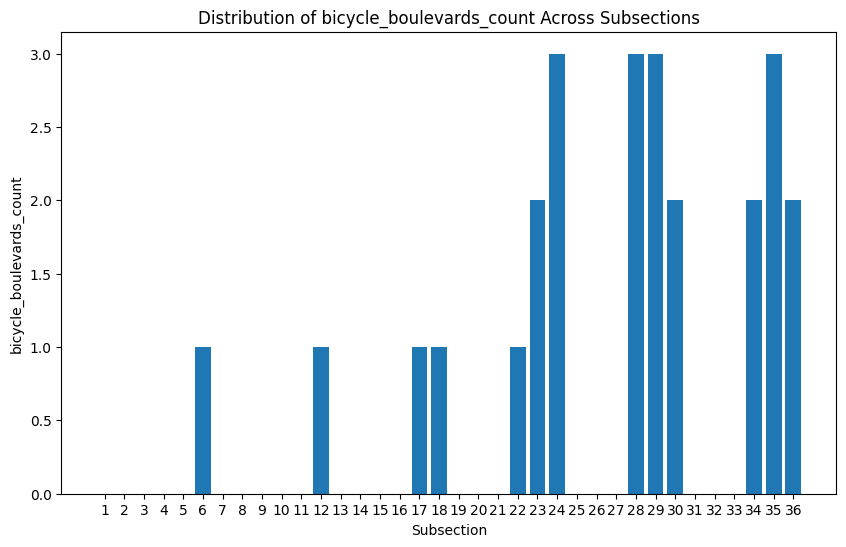

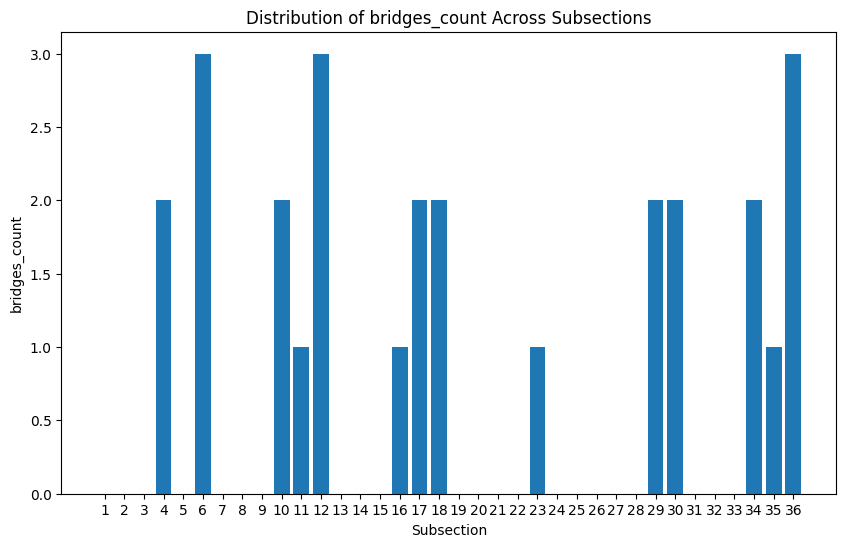

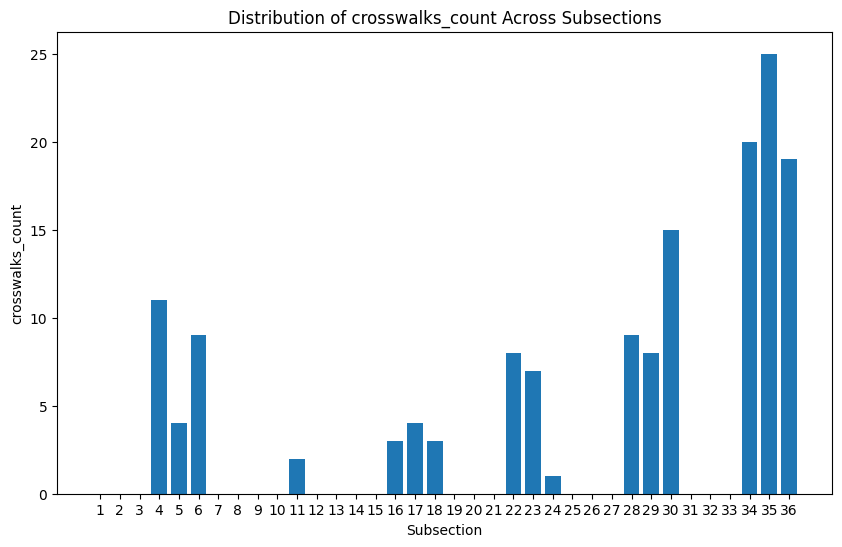

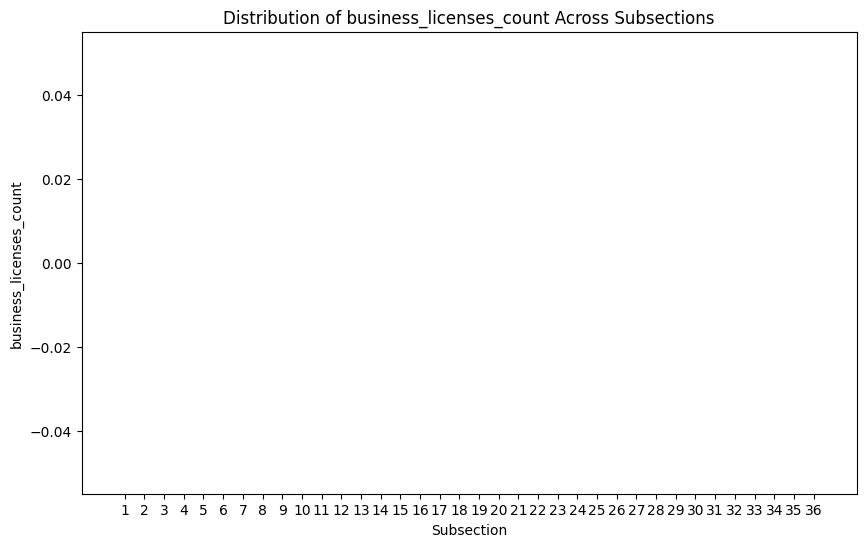

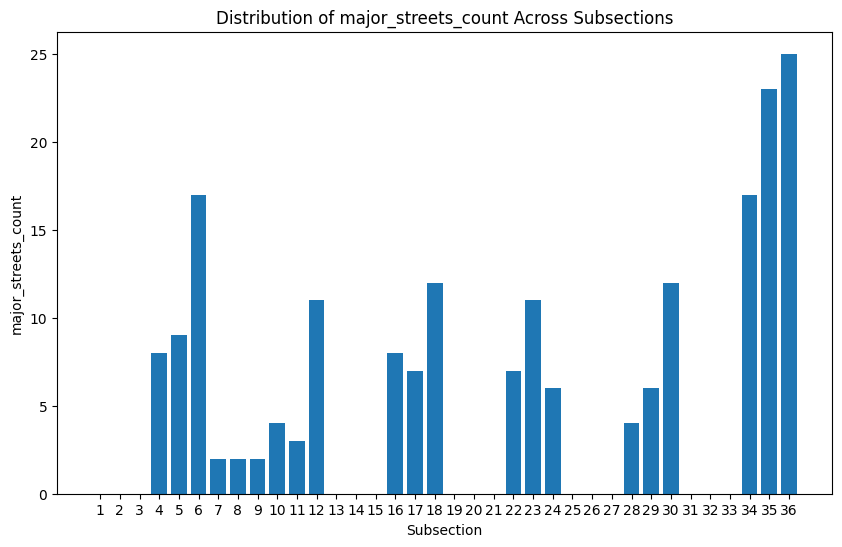

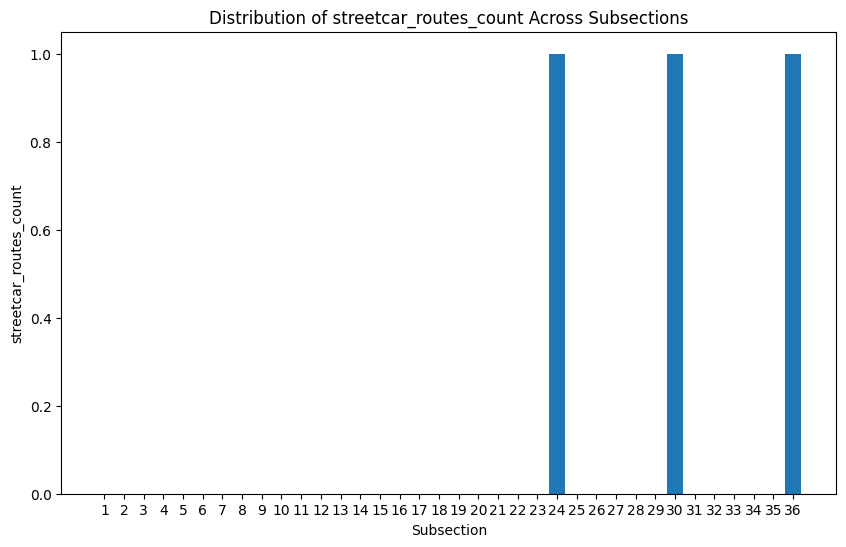

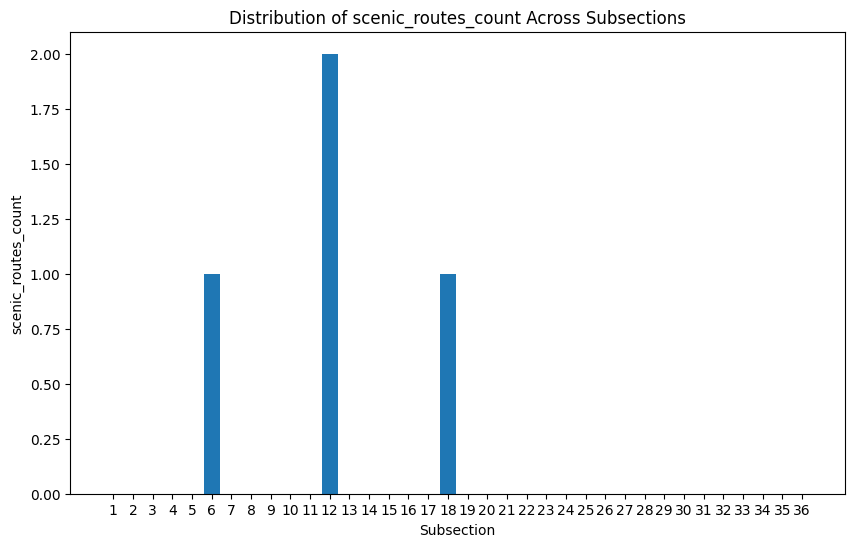

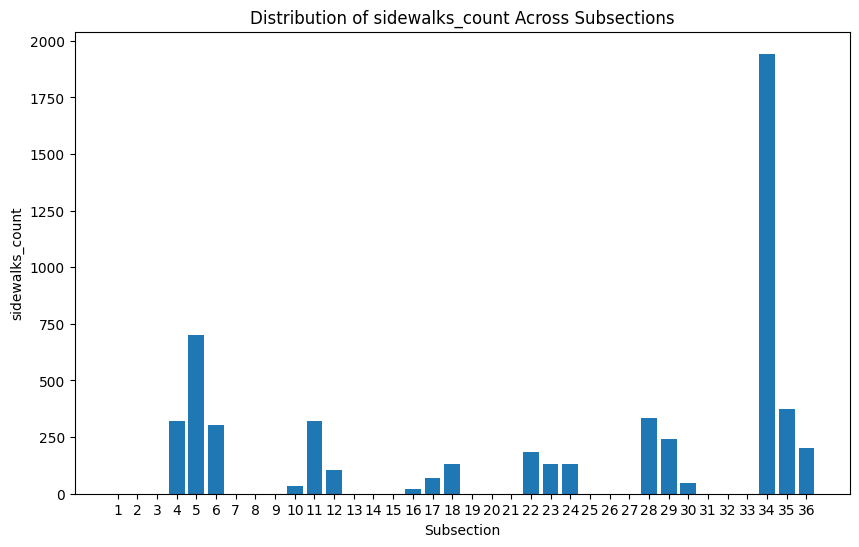

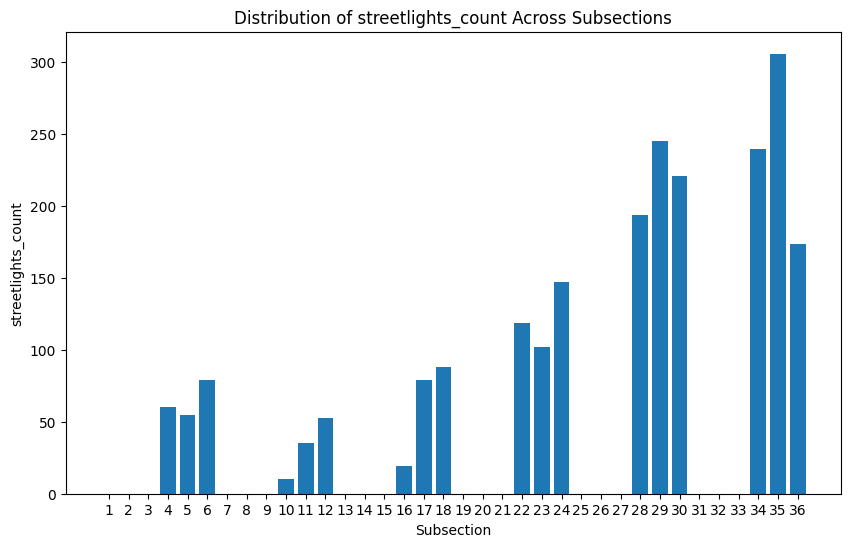

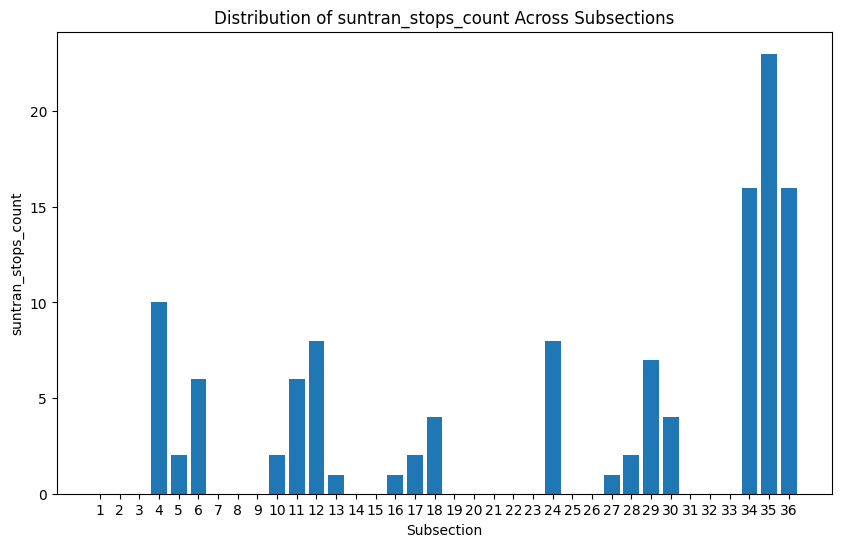

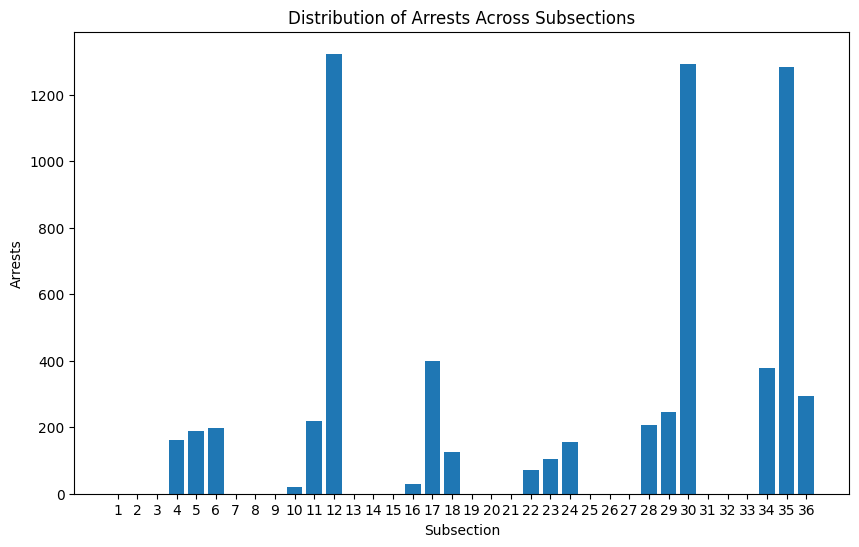

In [121]:
feature_names = counts_df.columns

# a full column corresponding to the feature
for feature in feature_names:
  x = counts_df[feature].tolist()
  visualize_single_feature(feature, x)

## 5—Model Training

### 5.1—Split Data into Training and Testing Sets

In [122]:
# Create train/test split
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train, test = train_test_split(
    counts_df, test_size=config["hp"]["test_size"], random_state=42
)

### 5.2—Normalize Data

Use sklear.preprocessing.StandardScaler to scale (normalize) the data

In [137]:
from sklearn.preprocessing import StandardScaler

X_features = counts_df.columns[:-1]  # All columns except the last one
features = counts_df.columns

# Initialize the StandardScaler
scaler = StandardScaler().fit(train[features])  # Scale feature columns

# Scaling is done after train/test split to avoid data leakage
train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])

# Display the scaled training data
print("Training data after scaling:")
print(train.head())
print("\nTesting data after scaling:")
print(test.head())

Training data after scaling:
               bicycle_boulevards_count  bridges_count  crosswalks_count  \
Subsection 9                  -0.668437      -0.775880         -0.639325   
Subsection 18                  0.222812       1.199088         -0.180322   
Subsection 10                 -0.668437       1.199088         -0.639325   
Subsection 35                  2.005312       0.211604          3.185697   
Subsection 1                  -0.668437      -0.775880         -0.639325   

               business_licenses_count  major_streets_count  \
Subsection 9                       0.0            -0.577955   
Subsection 18                      0.0             1.024296   
Subsection 10                      0.0            -0.257505   
Subsection 35                      0.0             2.786773   
Subsection 1                       0.0            -0.898405   

               streetcar_routes_count  scenic_routes_count  sidewalks_count  \
Subsection 9                 -0.27735            -0.3244

### 5.3—Split Data into Input ($X$) and Output ($y$) Data

In [138]:
# Split into X and y
target_name = "Arrests"
other = [col for col in train.columns if col != target_name]

X_train, y_train = train[other], train["Arrests"]
X_test, y_test = test[other], test["Arrests"]

### 5.4—Hyperparameter Tuning and Model Selection

#### Best Subsets

In [139]:
from itertools import combinations


# Create function to find subsets of features
def find_subsets(features, max_length):
    """
    Find all possible subsets of features up to a given maximum length.

    Parameters:
    features (list): The list of features to find subsets from.
    max_length (int): The maximum length of subsets to consider.

    Returns:
    set: A set of tuples containing subsets of features.
    """
    subsets = set()
    for L in range(1, max_length + 1):
        for subset in combinations(features, L):
            subsets.add(subset)
    return subsets

Best-performing set of features: ('major_streets_count', 'scenic_routes_count', 'sidewalks_count', 'suntran_stops_count') (R-squared = 0.0770760488831111)


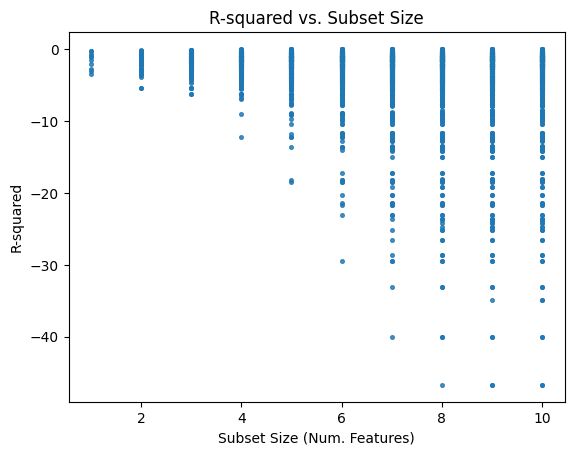

In [141]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression


best_subsets_lr = LinearRegression()
subset_sizes = []
r2_means_subsets = []
for subset_size in range(1, len(X_features) + 1):
    # Find all possible subsets of features for the current size
    subsets = find_subsets(X_features, subset_size)

    # Calculate the mean R^2 score for each subset
    for subset in subsets:
        mean_r2 = cross_val_score(
            best_subsets_lr,
            X_train[list(subset)],
            y_train,
            cv=config["hp"]["cross_val_folds"]["linear"],
            scoring=config["hp"]["scoring_metric"]["best_subset"],
        ).mean()
        subset_sizes.append(subset_size)
        r2_means_subsets.append((mean_r2, subset))

# plot the R-squared values vs. subset size
plt.scatter(subset_sizes, [r2 for r2, _ in r2_means_subsets], alpha=0.8, s=7)
plt.xlabel("Subset Size (Num. Features)")
plt.ylabel("R-squared")
plt.title("R-squared vs. Subset Size")

# report the best-performing subset of features
best_r2_subset_2, best_feature_combo = sorted(r2_means_subsets, key=lambda x: -x[0])[0]
print(
    f"Best-performing set of features: {best_feature_combo} (R-squared = {best_r2_subset_2})"
)

#### Ridge

Best R²: -0.111, Best α: 86.851


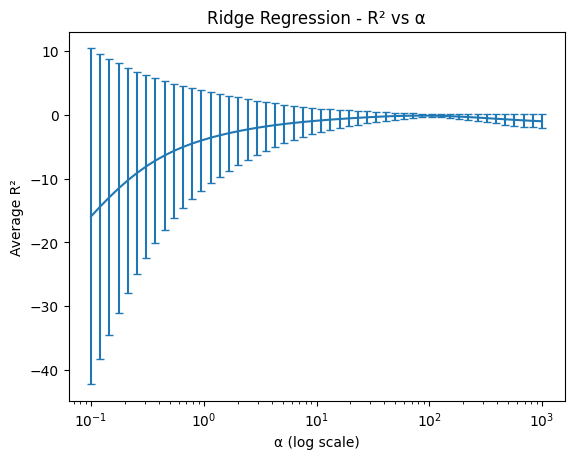

In [142]:
# Ridge Regression
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import numpy as np

# Create a range of 50 alpha values spaced logarithmically in the range [10^-1, 10^3]
domain = np.logspace(-1, 3, 50)

# find the best alpha value across domain
r2_means_ridge, r2_stds_ridge = [], []
for alpha in domain:
    reg = linear_model.Ridge(alpha=alpha)
    r2_vals = cross_val_score(reg, X_train, y_train, cv=config["hp"]["cross_val_folds"]["ridge"], scoring=config["hp"]["scoring_metric"]["ridge"])
    r2_means_ridge.append(r2_vals.mean())
    r2_stds_ridge.append(r2_vals.std())

# plot the R-squared values
plt.errorbar(domain, r2_means_ridge, yerr=r2_stds_ridge, fmt="-", capsize=3)
plt.xscale("log")
plt.title("Ridge Regression - R² vs α")
plt.xlabel("α (log scale)")
plt.ylabel("Average R²")

# report the best R-squared value and the corresponding alpha
best_r2_ridge = np.max(r2_means_ridge)
best_alpha_ridge = domain[np.argmax(r2_means_ridge)]
print(f"Best R²: {best_r2_ridge:.3f}, Best α: {best_alpha_ridge:.3f}")

#### Lasso

Best α: 0.4314 (MSE: 0.9354)


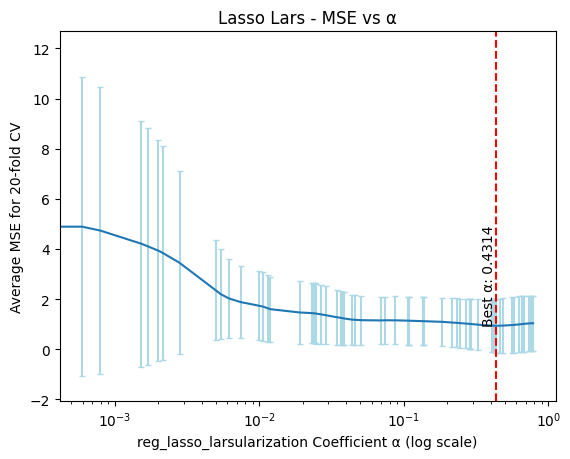

In [143]:
reg_lasso_lars = linear_model.LassoLarsCV(cv=config["hp"]["cross_val_folds"]["lasso"])
reg_lasso_lars.fit(X_train, y_train)

# plot the MSE for each α value
plt.errorbar(
    reg_lasso_lars.cv_alphas_,  # = α values
    reg_lasso_lars.mse_path_.mean(axis=1),  # = mean of MSE for each α across 20 folds
    yerr=reg_lasso_lars.mse_path_.std(
        axis=1
    ),  # = standard deviation of MSE for each α across 20 folds
    fmt="-",
    capsize=2,
    ecolor="lightblue",
)
plt.xscale("log")
plt.title("Lasso Lars - MSE vs α")
plt.xlabel("reg_lasso_larsularization Coefficient α (log scale)")
plt.ylabel("Average MSE for 20-fold CV")

# report the best alpha and the corresponding MSE
best_alpha_lasso = reg_lasso_lars.alpha_
best_mse_lasso = reg_lasso_lars.mse_path_.mean(axis=1)[
    np.where(reg_lasso_lars.cv_alphas_ == best_alpha_lasso)
][0]
print(f"Best α: {best_alpha_lasso:.4f} (MSE: {best_mse_lasso:.4f})")

# highlight best alpha on plot
plt.axvline(best_alpha_lasso, color="red", linestyle="--")
plt.text(
    best_alpha_lasso,
    best_mse_lasso,
    f"Best α: {best_alpha_lasso:.4f}",
    rotation=90,
    va="bottom",
    ha="right",
);

## 6—Model Evaluation

### 6.1—Evaluate Regression Types on Testing Data

##### Best Subsets

In [144]:
import sklearn.metrics
import statsmodels.api as sm

# use best combination of features from previous step to fit the model
best_subsets_lr = linear_model.LinearRegression()
best_subsets_lr.fit(X_train[list(best_feature_combo)], y_train)

# score the model's accuracy on the test data
r2_best_subsets = best_subsets_lr.score(X_test[list(best_feature_combo)], y_test)
preds_best_subsets = best_subsets_lr.predict(X_test[list(best_feature_combo)])
mse_best_subsets = sklearn.metrics.mean_squared_error(y_test, preds_best_subsets)

print(
    "Best Subsets:",
    f"Features Used: {best_feature_combo}",
    f"Coefficients: {best_subsets_lr.coef_}",
    f"MSE: {mse_best_subsets:.3f}",
    f"R²: {r2_best_subsets:.3f}\n",
    sep="\n\t",
)

# show an additional summary of the model
X_train_sm = sm.add_constant(X_train[list(best_feature_combo)])
model = sm.OLS(y_train, X_train_sm).fit()
print(model.summary())

Best Subsets:
	Features Used: ('major_streets_count', 'scenic_routes_count', 'sidewalks_count', 'suntran_stops_count')
	Coefficients: [ 0.3378005   0.21676415 -0.30245491  0.52728849]
	MSE: 0.518
	R²: -2.550

                            OLS Regression Results                            
Dep. Variable:                Arrests   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     8.895
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           0.000171
Time:                        05:46:07   Log-Likelihood:                -26.642
No. Observations:                  28   AIC:                             63.28
Df Residuals:                      23   BIC:                             69.94
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
 

##### Ridge

In [145]:
# use best alpha value from previous step to fit the model
reg_ridge = linear_model.Ridge(alpha=best_alpha_ridge)
reg_ridge.fit(X_train, y_train)

# score the model's accuracy on the test data
r2_ridge = reg_ridge.score(X_test, y_test)
preds_ridge = reg_ridge.predict(X_test)
mse_ridge = sklearn.metrics.mean_squared_error(y_test, preds_ridge)

print(
    "Ridge Regression:",
    f"Coefficients:{reg_ridge.coef_}",
    f"alpha = {best_alpha_ridge:.3f}",
    f"MSE = {mse_ridge:.3f}",
    f"R² = {r2_ridge:.3f}",
    sep="\n\t",
)

Ridge Regression:
	Coefficients:[ 0.05689409  0.06989352  0.08090442  0.          0.08628417  0.06736698
  0.08663238 -0.0080921   0.08096185  0.08893411]
	alpha = 86.851
	MSE = 0.172
	R² = -0.176


##### Lasso

In [146]:
# use the optimal regularization coefficient from the previous step to fit the model
reg_lasso = linear_model.Lasso(alpha=best_alpha_lasso)
reg_lasso.fit(X_train, y_train)

# score the model's accuracy on the test data
r2_lasso = reg_lasso.score(X_test, y_test)
preds_lasso = reg_lasso.predict(X_test)
mse_lasso = sklearn.metrics.mean_squared_error(preds_lasso, y_test)

print(
    "Lasso Regression:",
    f"Coefficients:{reg_lasso.coef_}",
    f"alpha = {reg_lasso.alpha}",
    f"MSE = {mse_lasso:.3f}",
    f"R² = {r2_lasso:.3f}",
    sep="\n\t",
)

Lasso Regression:
	Coefficients:[0.         0.         0.         0.         0.16873914 0.
 0.         0.         0.03758379 0.05727737]
	alpha = 0.43144378861827043
	MSE = 0.142
	R² = 0.024


### 5.4.5—Compare Feature Weights for each Model

In [147]:
feature_names = counts_df.columns[:-1]

model_names = ["Best Subset Regression", "Ridge Regression", "Lasso Regression"]
results_df = pd.DataFrame(columns=model_names, index=feature_names)

for i, feature in enumerate(feature_names):
    results_df.loc[feature] = [
        (
            best_subsets_lr.coef_[list(best_feature_combo).index(feature)]
            if feature in best_feature_combo
            else 0
        ),
        reg_ridge.coef_[i],
        reg_lasso.coef_[i],
    ]

# create another table comparing metrics
metrics_df = pd.DataFrame(columns=model_names, index=["MSE", "R²"])
metrics_df.loc["MSE"] = [mse_best_subsets, mse_ridge, mse_lasso]
metrics_df.loc["R²"] = [r2_best_subsets, r2_ridge, r2_lasso]
print("Model performance metrics:\n")
print(metrics_df)

print("\n\nModel Feature weights:")
results_df

Model performance metrics:

    Best Subset Regression Ridge Regression Lasso Regression
MSE               0.518209         0.171603         0.142395
R²               -2.550403        -0.175701         0.024408


Model Feature weights:


Best Subset Regression Ridge Regression  \
bicycle_boulevards_count                      0         0.056894   
bridges_count                                 0         0.069894   
crosswalks_count                              0         0.080904   
business_licenses_count                       0              0.0   
major_streets_count                      0.3378         0.086284   
streetcar_routes_count                        0         0.067367   
scenic_routes_count                    0.216764         0.086632   
sidewalks_count                       -0.302455        -0.008092   
streetlights_count                            0         0.080962   
suntran_stops_count                    0.527288         0.088934   

                         Lasso Regression  
bicycle_boulevards_count              0.0  
bridges_count                         0.0  
crosswalks_count                      0.0  
business_licenses_count               0.0  
major_streets_count              0.168739  
streetcar_routes_count                0.0  
scenic_routes_count                   0.0  
sidewalks_count                       0.0  
streetlights_count               0.037584  
suntran_stops_count              0.057277

## 7—Discussion and Visualization